### Module 0: Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import pprint
import os 
from time import time 
from dotenv import load_dotenv
import json
import argparse
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from openai import OpenAI
import certifi

## Importing VE libraries
from utils import *
from dataset_utils import read_wikiqa_data
from prompt_helper import get_joint_prompt_helper, normalize_prediction
from dataset_utils import read_wikiqa_data, wiki_evaluation

In [2]:
# Override bad SSL_CERT_FILE if set
os.environ["SSL_CERT_FILE"] = certifi.where()

load_dotenv()

True

In [3]:
client = OpenAI()

### Module 1: Answer Generation VE

In [67]:
# Defining args parameter
args = argparse.Namespace(
    # style="standard", # used for few shot
    style ="e-p", # used for consistency
    annotation="std",
    run_prediction=False,
    run_length_test=False,
    num_shot=5,
    train_slice=0,
    num_dev=5, # Test 10 instance, increase it later
    dev_slice=0,
    show_result=False,
    model="gpt3.5",
    show_prompt=False,
    temperature =0.7,
    engine = "gpt-3.5-turbo-0125",

)

# print(args)
if args.style == "e-p":
    args.helper = get_joint_prompt_helper(args.style)

In [62]:
def result_cache_name(args):
    return "misc/consistency_tr{}-{}_dv{}-{}_predictions_temp_{}.json".format(
        args.train_slice, args.train_slice + args.num_shot, args.dev_slice, args.num_dev,
        args.temperature)

In [11]:
# def in_context_prediction(ex, shots, engine, style="standard", length_test_only=False, n=1):

#     if style == "standard":
#         showcase_examples = [
#             "Q: {}\nA: {}\n".format(s["question"], s["answer"]) for s in shots
#         ]
#         input_example = "Q: {}\nA:".format(ex["question"])
#         prompt = "\n".join(showcase_examples + [input_example])
#     else:
#         raise RuntimeError("Unsupported prompt style")
    
#     temp = 0.7 if n > 1 else 0.0
#     pred = {}
#     responses = []
#     completion = client.chat.completions.create(
#         messages=[
#             {
#                 "role": "user",
#                 "content": prompt
#             }
#         ],
#         model=engine,
#         n= n,
#         temperature= temp
#     )
#     for choice in completion.choices:
#         responses.append(choice.message.content)

#     pred["responses"] = responses
#     pred["id"] = ex["id"]
#     pred["question"] = ex["question"]
#     pred["answer"] = ex["answer"]
#     return pred

In [38]:
# def test_few_shot_performance(args):
#     print("Running prediction")
#     train_set = read_wikiqa_data(f"data/train_subset.json")
#     train_set = train_set[args.train_slice:(args.train_slice + args.num_shot)]
#     dev_set = read_wikiqa_data(f"data/dev_sampled.json")
#     dev_set = dev_set[args.dev_slice:(args.num_dev)]

#     showcase_examples = [
#         "Q: {}\nA: {}\n".format(s["question"], s["answer"]) for s in train_set
#     ]
#     prompt = "\n".join(showcase_examples)

#     predictions = []
#     for x in tqdm(dev_set, total=len(dev_set), desc="Predicting"):
#         pred = in_context_prediction(x, train_set, engine=args.engine, \
#             style="standard", length_test_only=args.run_length_test, n = args.num_shot)
#         if pred == None:
#             args.num_dev = len(predictions)
#             break
#         else:
#             predictions.append(pred)

#     return predictions
    

In [39]:
# predictions = test_few_shot_performance(args)

### Module: COT Prediction

In [15]:
def in_context_manual_prediction(ex, training_data, engine, prompt_helper, length_test_only=False, n= 1):
    prompt, stop_signal = prompt_helper.prompt_for_joint_prediction(ex, training_data)

    temp = 0.7 if n > 1 else 0.0
    pred = {}
    responses = []
    completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ],
        model=engine,
        n= n,
        temperature= temp
    )
    for choice in completion.choices:
        responses.append(choice.message.content)

    pred["responses"] = responses
    pred["id"] = ex["id"]
    pred["question"] = ex["question"]
    pred["answer"] = ex["answer"]

    return pred

In [40]:
# def test_few_shot_manual_prediction(args):
#     print("Running prediction")
#     train_set = read_wikiqa_data(f"data/train_subset.json", manual_annotation_style=args.style)
#     train_set = train_set[args.train_slice:(args.train_slice + args.num_shot)]
#     print('len(train_set): ', len(train_set))
#     dev_set = read_wikiqa_data(f"data/dev_sampled.json")
#     dev_set = dev_set[args.dev_slice:(args.num_dev)]

#     prompt, _ = args.helper.prompt_for_joint_prediction(dev_set[0], train_set)
#     # print('prompt: ')
#     # print(prompt)

#     predictions = []    
#     for i, x in enumerate(tqdm(dev_set, total=len(dev_set), desc="Predicting")):
#         pred = in_context_manual_prediction(x, train_set, engine=args.engine, prompt_helper=args.helper, length_test_only=args.run_length_test, n = args.num_shot)
#         if pred != None:
#             predictions.append(pred)
#         else:
#             print('ENDING EARLY')
#             args.num_dev = i + args.dev_slice
#             # dump_json(predictions, result_cache_name(args))
#             raise Exception('end')
    
#     return predictions

In [41]:
# predictions = test_few_shot_manual_prediction(args)

In [18]:
predictions

[{'responses': ['First, the performer of the song Get A Life - Get Alive is Bryan Adams. Second, Bryan Adams was born in Kingston, Ontario, Canada. The answer is Kingston, Ontario, Canada.',
   'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England. The answer is London, England.',
   'First, the performer of the song Get A Life - Get Alive is Sasha Lazard. Second, Sasha Lazard was born in New York City, New York, USA. The answer is New York City, New York, USA.',
   'First, the performer of the song Get A Life - Get Alive is Ian Gillan. Second, Ian Gillan was born in Hounslow, London, England. The answer is Hounslow, London, England.',
   ' First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England. The answer is London, England.'],
  'id': '1ee47f380bde11eba7f7acde48001122',
  'question': 'Where was the performer of song Get A Life – Get Alive born?',

### Module 2: Evaluating Few Shot performance

Note: Still in progress

In [42]:
# def evaluate_few_shot_predictions(dev_set, predictions, do_print=False):
#     acc_records = []    
#     f1_records, pre_records, rec_records = [], [], []
#     logprob_records = []
    
#     for idx, (ex, pred) in enumerate(zip(dev_set, predictions)):
#         p_ans = pred['text'].lstrip()
#         acc, (f1, pre, rec), gt_ans = wiki_evaluation(p_ans, ex["answer"])
#         acc_records.append(acc)                
#         f1_records.append(f1), pre_records.append(pre), rec_records.append(rec)
#         if 'answer_prob' in pred:
#             logprob_records.append(pred['answer_prob'])
#         if do_print and not acc:
#             print("--------------{} EX {} F1 {:.2f}--------------".format(idx, acc, f1))
#             print(ex['question'])
#             print('PR ANS:', p_ans)            
#             print('GT ANS:', gt_ans)            
#             print(json.dumps({'qas_id': ex['id'], 'answer': p_ans}))

#     mean_of_array = lambda x: sum(x) / len(x)
#     print("EX", mean_of_array(acc_records))
#     print("F1: {:.2f}".format(mean_of_array(f1_records)), 
#             "PR: {:.2f}".format(mean_of_array(pre_records)),
#             "RE: {:.2f}".format(mean_of_array(rec_records)))
#     print("Acc-Cov AUC: {:.2f}".format(f1auc_score(
#             logprob_records, acc_records)))

### Module 3: Calculting Consistency

In [20]:
len(predictions)

2

In [21]:
p = predictions[0]
p

{'responses': ['First, the performer of the song Get A Life - Get Alive is Bryan Adams. Second, Bryan Adams was born in Kingston, Ontario, Canada. The answer is Kingston, Ontario, Canada.',
  'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England. The answer is London, England.',
  'First, the performer of the song Get A Life - Get Alive is Sasha Lazard. Second, Sasha Lazard was born in New York City, New York, USA. The answer is New York City, New York, USA.',
  'First, the performer of the song Get A Life - Get Alive is Ian Gillan. Second, Ian Gillan was born in Hounslow, London, England. The answer is Hounslow, London, England.',
  ' First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England. The answer is London, England.'],
 'id': '1ee47f380bde11eba7f7acde48001122',
 'question': 'Where was the performer of song Get A Life – Get Alive born?',
 'answ

In [22]:
answers, rationales = [], []
for choice in p['responses']:
    # first split the rationales
    answer, rationale = args.helper.post_process_prediction(choice, change_rationale = False)
    answers.append(answer)
    rationales.append(rationale)

In [23]:
answers, rationales

(['Kingston, Ontario, Canada',
  'London, England',
  'New York City, New York, USA',
  'Hounslow, London, England',
  'London, England'],
 ['First, the performer of the song Get A Life - Get Alive is Bryan Adams. Second, Bryan Adams was born in Kingston, Ontario, Canada.',
  'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England.',
  'First, the performer of the song Get A Life - Get Alive is Sasha Lazard. Second, Sasha Lazard was born in New York City, New York, USA.',
  'First, the performer of the song Get A Life - Get Alive is Ian Gillan. Second, Ian Gillan was born in Hounslow, London, England.',
  'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England.'])

In [24]:
def consistency(answers, rationales, predictions):
    answer_probs = {}
    # answer_prob_lists = {}
    choices = predictions['responses']
    for i, ans in enumerate(answers):
        # logprobs = np.array(choices[i]['logprobs']['token_logprobs'][prompt_tokens:])
        # prob = np.exp(np.mean(logprobs))
        if ans in answer_probs.keys():
            # answer_prob_lists[ans].append((i, prob))
            answer_probs[ans] += 1
        else:
            # answer_prob_lists[ans] = [(i, prob)]
            answer_probs[ans] = 1
    consistency = max(list(answer_probs.values()))/5
    final_aggregated_answer = sorted(answer_probs.items(), key=lambda item: item[1], reverse=True)[0][0]
    best_i = list(answer_probs.keys()).index(final_aggregated_answer)
    # prob_list = answer_prob_lists[final_aggregated_answer]
    # best_i = prob_list[np.argmax([a[1] for a in prob_list])][0]
    final_aggregated_rationale = rationales[best_i]
    return consistency, final_aggregated_answer, final_aggregated_rationale, best_i
    # return consistency, final_aggregated_answer

In [25]:
con, best_answer, best_rationale, best_i= consistency(answers, rationales, p)

In [47]:
def post_process_consistency(ex, p, args):
    answers, rationales = [], []
    for choice in p['responses']:
        # first split the rationales
        answer, rationale = args.helper.post_process_prediction(choice, change_rationale = False)
        answers.append(answer)
        rationales.append(rationale)
    # prompt_tokens = p['usage']['prompt_tokens']
    con, best_answer, best_rationale, best_i = consistency(answers, rationales, p)
    # new_p = p['choices'][best_i]
    new_p = {'response': p['responses'][best_i]}
    new_p['id'] = ex['id']
    new_p['consistency'] = con
    new_p['rationale'] = best_rationale
    new_p['answer'] = best_answer
    new_p['original_answers'] = answers
    new_p['original_rationales'] = rationales
    return con, new_p

In [27]:
new_p

{'response': 'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England. The answer is London, England.',
 'consistency': 0.4,
 'original_best_rationale': 'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England.',
 'original_best_answer': 'London, England',
 'original_answers': ['Kingston, Ontario, Canada',
  'London, England',
  'New York City, New York, USA',
  'Hounslow, London, England',
  'London, England'],
 'original_rationales': ['First, the performer of the song Get A Life - Get Alive is Bryan Adams. Second, Bryan Adams was born in Kingston, Ontario, Canada.',
  'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England.',
  'First, the performer of the song Get A Life - Get Alive is Sasha Lazard. Second, Sasha Lazard was born in New York City, New York, USA.',
  'First, the perf

In [28]:
p_ans = 'Nellore, Andhra Pradesh, India'
ex_ans = 'Vöcklabruck'

In [29]:
wiki_evaluation(p_ans, ex_ans)

(False, (0, 0, 0), 'Vöcklabruck')

In [9]:
def evaluate_manual_predictions(dev_set, predictions, style="p-e", do_print=False):
    acc_records = []
    rat_records = []
    f1_records, pre_records, rec_records = [], [], []
    # logprob_records = []
    # ansprob_records = []

    true_cons = []
    false_cons = []
    for idx, (ex, pred) in enumerate(zip(dev_set, predictions)):
        p_ans = pred['answer']
        p_rat = pred['rationale']
        acc, (f1, pre, rec), gt_ans = wiki_evaluation(p_ans, ex["answer"])
        acc_records.append(acc)
        rat_acc = False
        rat_records.append(rat_acc)
        f1_records.append(f1), pre_records.append(pre), rec_records.append(rec)
        # logprob_records.append(pred['joint_lobprob'])
        # ansprob_records.append(pred['answer_logprob'])
        if acc:
            true_cons.append(pred['consistency'])
        else:
            false_cons.append(pred['consistency'])

        if do_print:
            print("--------------{} EX {} RAT {} F1 {:.2f} CONS {:.2f}--------------".format(idx, acc, rat_acc, f1, pred['consistency']))
            print('question: ', ex['question'])
            for (i, answer) in enumerate(pred['original_answers']):
                rat = pred['original_rationales'][i]
                print(f'{i}: {rat} | {answer}')
            print('PR ANS:', p_ans)
            print('PR RAT:', p_rat)
            print('GT ANS:', gt_ans)
            print(json.dumps({'qas_id': ex['id'], 'answer': p_ans}))

    mean_of_array = lambda x: sum(x) / len(x)
    print("EX", mean_of_array(acc_records), "RAT", mean_of_array(rat_records))
    print("F1: {:.2f}".format(mean_of_array(f1_records)), 
            "PR: {:.2f}".format(mean_of_array(pre_records)),
            "RE: {:.2f}".format(mean_of_array(rec_records)))
    # print("Acc-Cov AUC: {:.2f}".format(f1auc_score(
    #         ansprob_records, acc_records)))
    
    cons = true_cons + false_cons
    print('consistencies: mean {} and std {}'.format(np.mean(cons), np.std(cons)))
    
    print('consistencies for true predictions: mean {} and std {}'.format(np.mean(true_cons), np.std(true_cons)))
    print('consistencies for false predictions: mean {} and std {}'.format(np.mean(false_cons), np.std(false_cons)))
    return true_cons, false_cons

In [45]:
### Final Function to use predictions for consistency

def test_few_shot_manual_prediction(args):
    print("Running prediction")
    train_set = read_wikiqa_data(f"data/train_subset.json", manual_annotation_style=args.style)
    train_set = train_set[args.train_slice:(args.train_slice + args.num_shot)]
    print('len(train_set): ', len(train_set))
    dev_set = read_wikiqa_data(f"data/dev_sampled.json")
    dev_set = dev_set[args.dev_slice:(args.num_dev)]

    prompt, _ = args.helper.prompt_for_joint_prediction(dev_set[0], train_set)
    # print('prompt: ')
    # print(prompt)


    predictions = []    
    for x in tqdm(dev_set, total=len(dev_set), desc="Predicting"):
        pred = in_context_manual_prediction(x, train_set, engine=args.engine, prompt_helper=args.helper, length_test_only=args.run_length_test, n = args.num_shot)
        if pred != None:
            predictions.append(pred)
        else: #error, ending early
            args.num_dev = len(predictions) + args.dev_slice
            break
            
        # # save
        # dump_json(predictions, result_cache_name(args))   
    
    new_predictions, cons = [], []
    for i, p in enumerate(tqdm(predictions, total=len(predictions), desc="Verifying")):
        ex = dev_set[i]
        con, new_p = post_process_consistency(ex, p, args)
        cons.append(con)
        new_predictions.append(new_p)
    predictions = new_predictions 

    # true_cons, false_cons = evaluate_manual_predictions(dev_set, predictions, args.style, do_print=True)
    # print(result_cache_name(args))
    return predictions
    # return predictions, true_cons, false_cons

In [46]:
test_few_shot_manual_prediction(args)

Running prediction
0 not found
len(train_set):  5
7 not found


Verifying: 100%|██████████| 2/2 [00:00<00:00, 14488.10it/s]


[{'response': 'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England. The answer is England.',
  'id': '1ee47f380bde11eba7f7acde48001122',
  'consistency': 0.4,
  'original_best_rationale': 'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England.',
  'original_best_answer': 'England',
  'original_answers': ['Mumbai, India',
   'England',
   'London, England',
   'England',
   'London, England'],
  'original_rationales': ['First, the performer of the song Get A Life - Get Alive is Sajid Khan. Second, Sajid Khan was born in Mumbai, India.',
   'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England.',
   'First, the performer of the song Get A Life - Get Alive is Ian Curnow. Second, Ian Curnow was born in London, England.',
   'First, the performer of the song Get A Life - Get Alive 

In [64]:
### Final Function to use predictions for consistency

def test_few_shot_manual_prediction(args):
    print("Running prediction")
    train_set = read_wikiqa_data(f"data/train_subset.json", manual_annotation_style=args.style)
    train_set = train_set[args.train_slice:(args.train_slice + args.num_shot)]
    print('len(train_set): ', len(train_set))
    dev_set = read_wikiqa_data(f"data/dev_sampled.json")
    dev_set = dev_set[args.dev_slice:(args.num_dev)]

    prompt, _ = args.helper.prompt_for_joint_prediction(dev_set[0], train_set)
    # print('prompt: ')
    # print(prompt)


    predictions = []    
    for x in tqdm(dev_set, total=len(dev_set), desc="Predicting"):
        pred = in_context_manual_prediction(x, train_set, engine=args.engine, prompt_helper=args.helper, length_test_only=args.run_length_test, n = args.num_shot)
        if pred != None:
            predictions.append(pred)
        else: #error, ending early
            args.num_dev = len(predictions) + args.dev_slice
            break
            
        # # save
    dump_json(predictions, result_cache_name(args))   
    
    new_predictions, cons = [], []
    for i, p in enumerate(tqdm(predictions, total=len(predictions), desc="Verifying")):
        ex = dev_set[i]
        con, new_p = post_process_consistency(ex, p, args)
        cons.append(con)
        new_predictions.append(new_p)
    predictions = new_predictions 

    true_cons, false_cons = evaluate_manual_predictions(dev_set, predictions, args.style, do_print=True)

    cons = [p['consistency'] for p in predictions]
    plt.figure(figsize=(10,5))
    df = pd.DataFrame.from_dict({'label': ['correct']*len(true_cons) + ['incorrect']*len(false_cons) + ['overall']*(len(true_cons)+len(false_cons))\
        , 'consistency': true_cons + false_cons + cons})
    sns.displot(df, x="consistency", hue="label", kind="kde", fill=True)
    plt.savefig(f"log/consistency_2.png")
    

    return predictions, true_cons, false_cons

Running prediction
0 not found
len(train_set):  5
7 not found


Verifying: 100%|██████████| 5/5 [00:00<00:00, 11131.38it/s]

--------------0 EX False RAT False F1 0.00 CONS 0.40--------------
question:  Where was the performer of song Get A Life – Get Alive born?
0: First, the performer of the song Get A Life – Get Alive is Steve Winwood. Second, Steve Winwood was born in Handsworth, Birmingham, England. | Handsworth, Birmingham, England
1: First, the performer of the song Get A Life - Get Alive is Ian Dury. Second, Ian Dury was born in Harrow, Middlesex, England. | England
2: First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England. | London, England
3: First, the performer of the song Get A Life - Get Alive is Ian Astbury. Second, Ian Astbury was born in Heswall, England. | Heswall, England
4: First, the performer of the song Get A Life – Get Alive is Ian Astbury. Second, Ian Astbury was born in Heswall, Cheshire, England. | England
PR ANS: England
PR RAT: First, the performer of the song Get A Life - Get Alive is Ian Dury. Second, Ian Dury


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar div

([{'response': 'First, the performer of the song Get A Life - Get Alive is Ian Dury. Second, Ian Dury was born in Harrow, Middlesex, England. The answer is England.',
   'id': '1ee47f380bde11eba7f7acde48001122',
   'consistency': 0.4,
   'rationale': 'First, the performer of the song Get A Life - Get Alive is Ian Dury. Second, Ian Dury was born in Harrow, Middlesex, England.',
   'answer': 'England',
   'original_answers': ['Handsworth, Birmingham, England',
    'England',
    'London, England',
    'Heswall, England',
    'England'],
   'original_rationales': ['First, the performer of the song Get A Life – Get Alive is Steve Winwood. Second, Steve Winwood was born in Handsworth, Birmingham, England.',
    'First, the performer of the song Get A Life - Get Alive is Ian Dury. Second, Ian Dury was born in Harrow, Middlesex, England.',
    'First, the performer of the song Get A Life - Get Alive is Soul II Soul. Second, Soul II Soul was formed in London, England.',
    'First, the perform

<Figure size 1000x500 with 0 Axes>

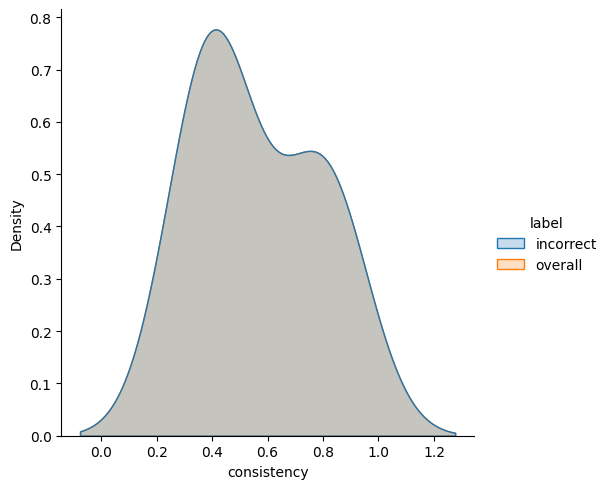

In [68]:
test_few_shot_manual_prediction(args)

### Verifying Questions Generation

In [69]:
def test_few_shot_manual_prediction(args):
    print("Running prediction")
    train_set = read_wikiqa_data(f"data/train_subset.json", manual_annotation_style=args.style)
    train_set = train_set[args.train_slice:(args.train_slice + args.num_shot)]
    print('len(train_set): ', len(train_set))
    dev_set = read_wikiqa_data(f"data/dev_sampled.json")
    dev_set = dev_set[args.dev_slice:(args.num_dev)]

    prompt, _ = args.helper.prompt_for_question_generation('question', 'sentence')
    print('prompt: ')
    print(prompt)

In [70]:
test_few_shot_manual_prediction(args)

Running prediction
0 not found
len(train_set):  5
7 not found
prompt: 
Write a question that validates the reason for an overall question.

Overall Question: What is the date of death of the composer of film Baalaraajana Kathe?
Reason: First, the composer of film Baalaraajana Kathe is S. Hanumantha Rao.
Question: Who is the composer of film Baalaraajana Kathe?

Overall Question: Who lived longer, Edward Frederick Sanderson or Forrest Towns?
Reason: First, Edward Frederick Sanderson died at age 81.
Question: How long did Edward Frederick Sanderson live for?

Overall Question: question
Reason: sentence
Question:


In [5]:
engine = "gpt-3.5-turbo-0125"

In [7]:
completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Tell me a joke"
        }
    ],
    model=engine,
    n= 1,
    temperature= 0
)

In [8]:
completion

ChatCompletion(id='chatcmpl-BUE3tsuQ0GBOSxfVd84P6Yf50XynP', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Why couldn't the bicycle stand up by itself?\n\nBecause it was two tired!", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1746543593, model='gpt-3.5-turbo-0125', object='chat.completion', service_tier='default', system_fingerprint=None, usage=CompletionUsage(completion_tokens=17, prompt_tokens=11, total_tokens=28, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

In [9]:
text = ''
for choice in completion.choices:
    text = choice.message.content

In [12]:
completion.choices[0].message.content

"Why couldn't the bicycle stand up by itself?\n\nBecause it was two tired!"

In [10]:
text

"Why couldn't the bicycle stand up by itself?\n\nBecause it was two tired!"